In [3]:
import scanpy as sc
import os
import numpy as np
from tqdm.notebook import tqdm
import glob
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import scvi

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
input_folders = glob.glob('/mnt/sata1/Analysis_Alex/timecourse_replicates/day*')

In [5]:
ad_sp = []
for input_file in input_folders:
    adata = sc.read(os.path.join(input_file, 'adatas', '10_axes_defined.h5ad'))
    ad_sp.append(adata)

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
ad_sp = sc.concat(ad_sp)

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Calculate the final UMAP

In [8]:
ad_sp.obsm['X_mde'] = scvi.model.utils.mde(ad_sp.obsm['X_scVI_replicates'])


/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


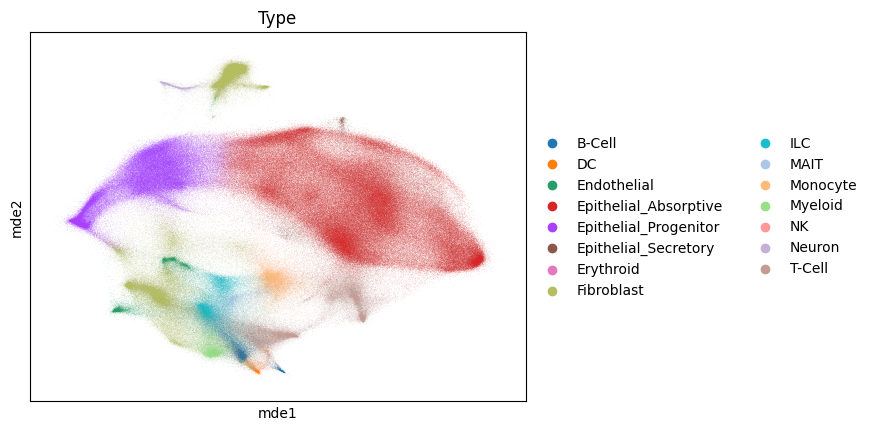

In [11]:
sc.pl.embedding(ad_sp, basis='mde', color='Subtype')

In [17]:
ad_sp.obs = ad_sp.obs.drop(ad_sp.obs.columns[ad_sp.obs.columns.str.contains('Topic ')], axis=1)

Write out combined object to an output folder

In [1]:
output_folder = r'/mnt/sata1/Analysis_Alex/timecourse_replicates/analysis/cleaned'

In [21]:
ad_sp.write(os.path.join(output_folder, 'integrated_celltyped.h5ad'))

In [ ]:
import scanpy as sc
import os
ad_sp = sc.read(os.path.join(output_folder, 'integrated_celltyped.h5ad'))
sc.pl.embedding(ad_sp, basis='mde', color='Subtype')

In [25]:

concatenated_all = sc.read(os.path.join(output_folder, 'integrated_celltyped.h5ad'))

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### We also want to clip our epithelial values at 0.6 for visualization

In [26]:
concatenated_all.obs['epithelial_distance_clipped'] = np.clip(concatenated_all.obs['epithelial_distance'].values, 0, 0.6)

### We also have an issue with some of the longitudinal being backwards. We can plot Guca2a expression to find which ones to flip

In [27]:
unique_bat = np.unique(concatenated_all.obs.batch)

In [28]:
import scipy.stats as stats
sc.set_figure_params(dpi=150)
for i in unique_bat:
    longit = concatenated_all[(concatenated_all.obs.batch == i) & concatenated_all.obs.not_removed_from_longitudinal].obs['predicted_longitudinal']
    guca2a = concatenated_all[(concatenated_all.obs.batch == i) & concatenated_all.obs.not_removed_from_longitudinal].X[:, concatenated_all[concatenated_all.obs.batch == i].var.index.isin(['Guca2a'])].flatten()
    print(stats.spearmanr(longit, guca2a), i)
    #sc.pl.embedding(concatenated_all[concatenated_all.obs.batch == i], basis='spatial', color='Guca2a', vmax=1, cmap='Blues', title=i)

SignificanceResult(statistic=-0.2808998578905462, pvalue=0.0) day30_SI_r2
SignificanceResult(statistic=-0.10610011059477703, pvalue=0.0) day6_SI_r2
SignificanceResult(statistic=-0.20236994163095384, pvalue=0.0) day8_SI_r2
SignificanceResult(statistic=-0.26048908663193804, pvalue=0.0) day90_SI_r2


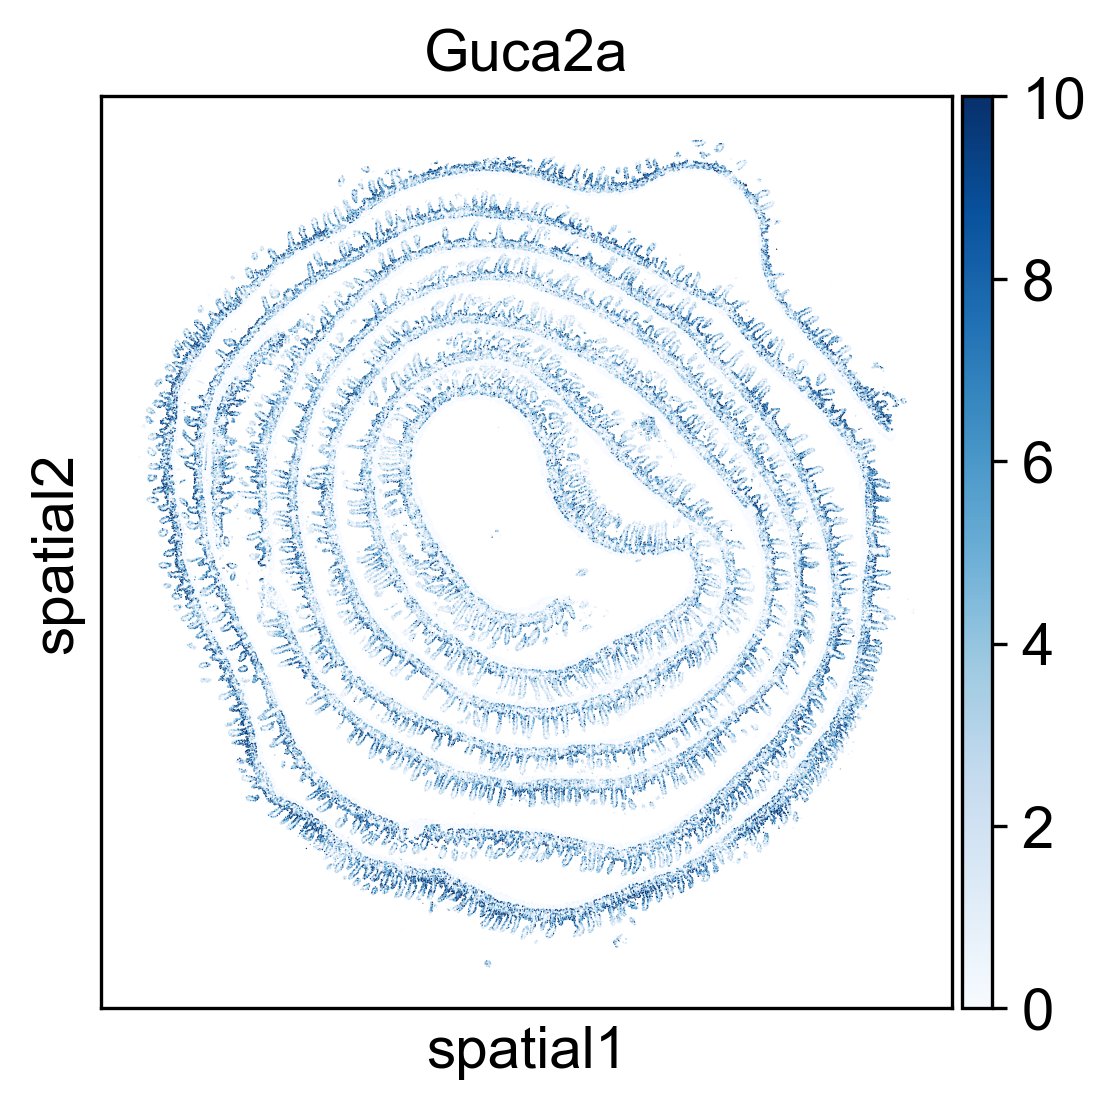

In [32]:
sc.pl.embedding(concatenated_all[concatenated_all.obs.batch == 'day6_SI_r2'], basis='spatial', color='Guca2a', vmax=10, cmap='Blues')

In [33]:
# outer if negative inner if positive
longitude = {'day6_SI_r2': 'outer', 'day8_SI_r2': 'outer', 'day30_SI_r2': 'outer', 'day90_SI_r2': 'outer'}

In [34]:
guca2a_expression = [longitude.get(i) for i in concatenated_all.obs.batch.values]

In [35]:
new_longitudinal = np.zeros(len(concatenated_all.obs))

In [36]:
for i in unique_bat:
    indices = np.where(concatenated_all.obs.batch.values == i)[0]
    if longitude.get(i) == 'outer':
        new_longitudinal[indices] = 1 - concatenated_all[indices, :].obs.predicted_longitudinal.values
    elif longitude.get(i) == 'inner':
        new_longitudinal[indices] = concatenated_all[indices, :].obs.predicted_longitudinal.values

In [37]:
concatenated_all.obs['predicted_longitudinal'] = new_longitudinal

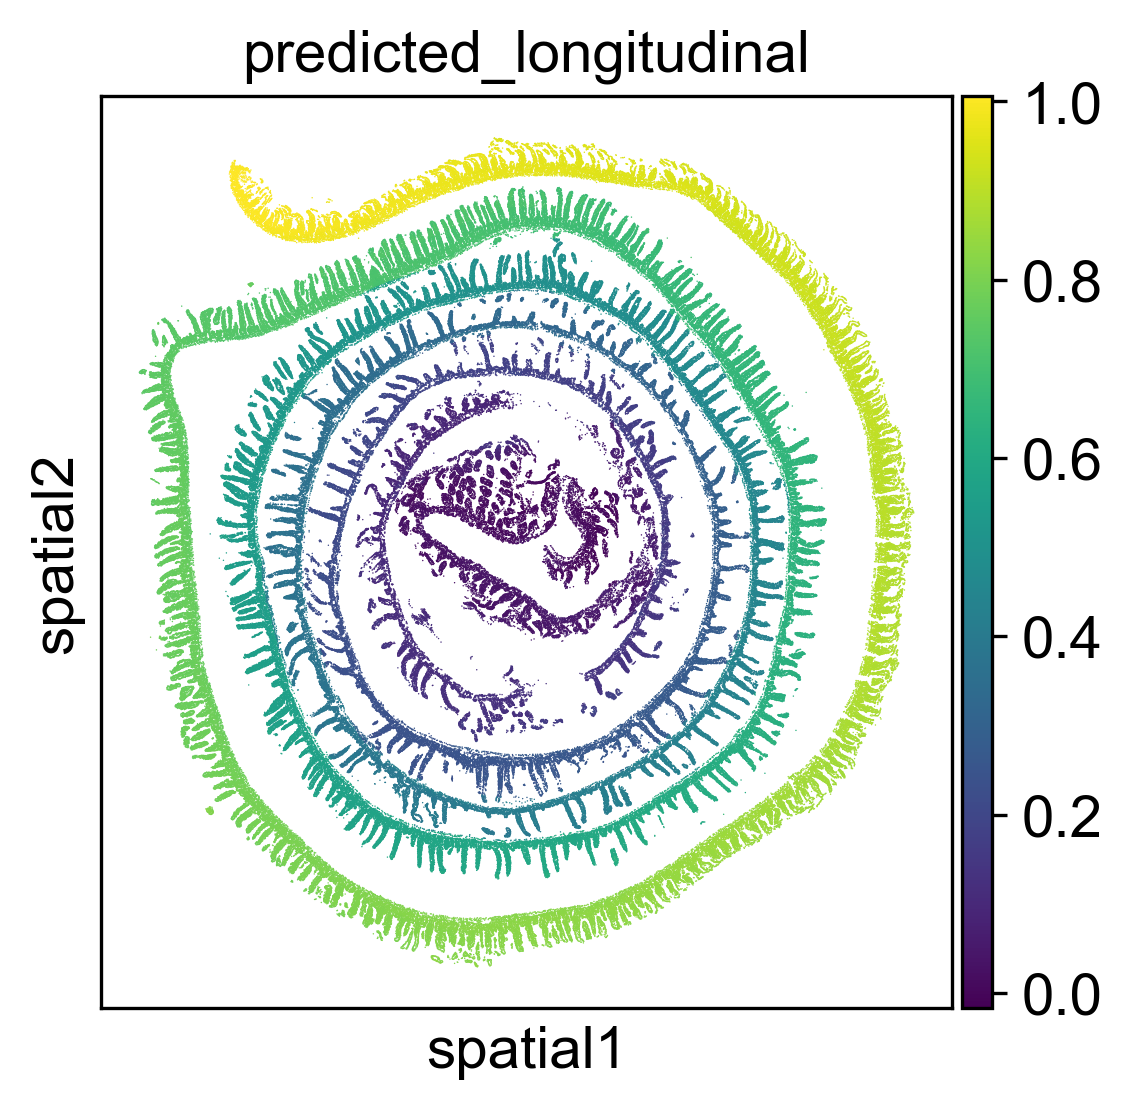

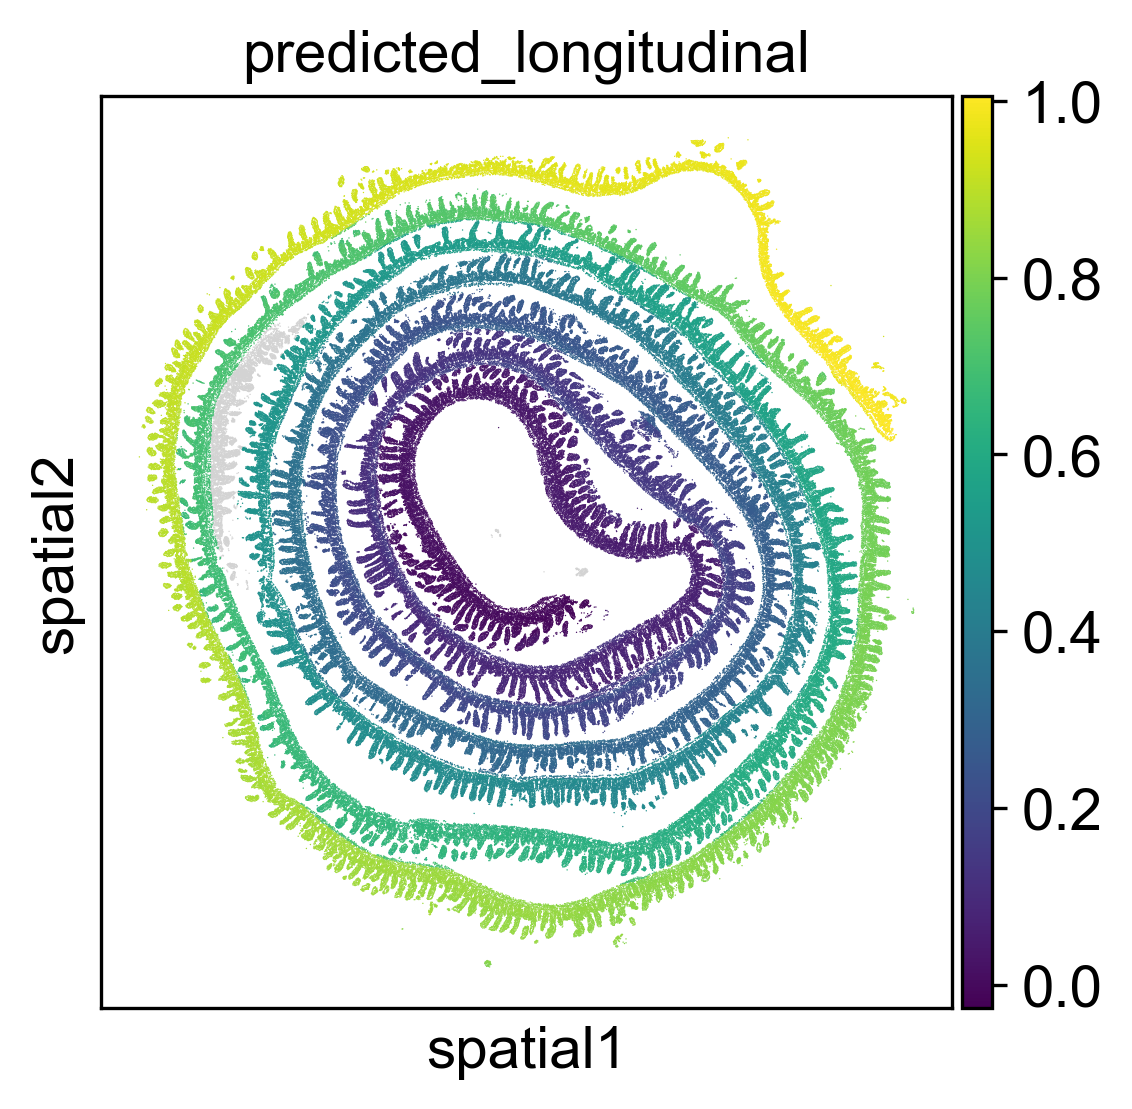

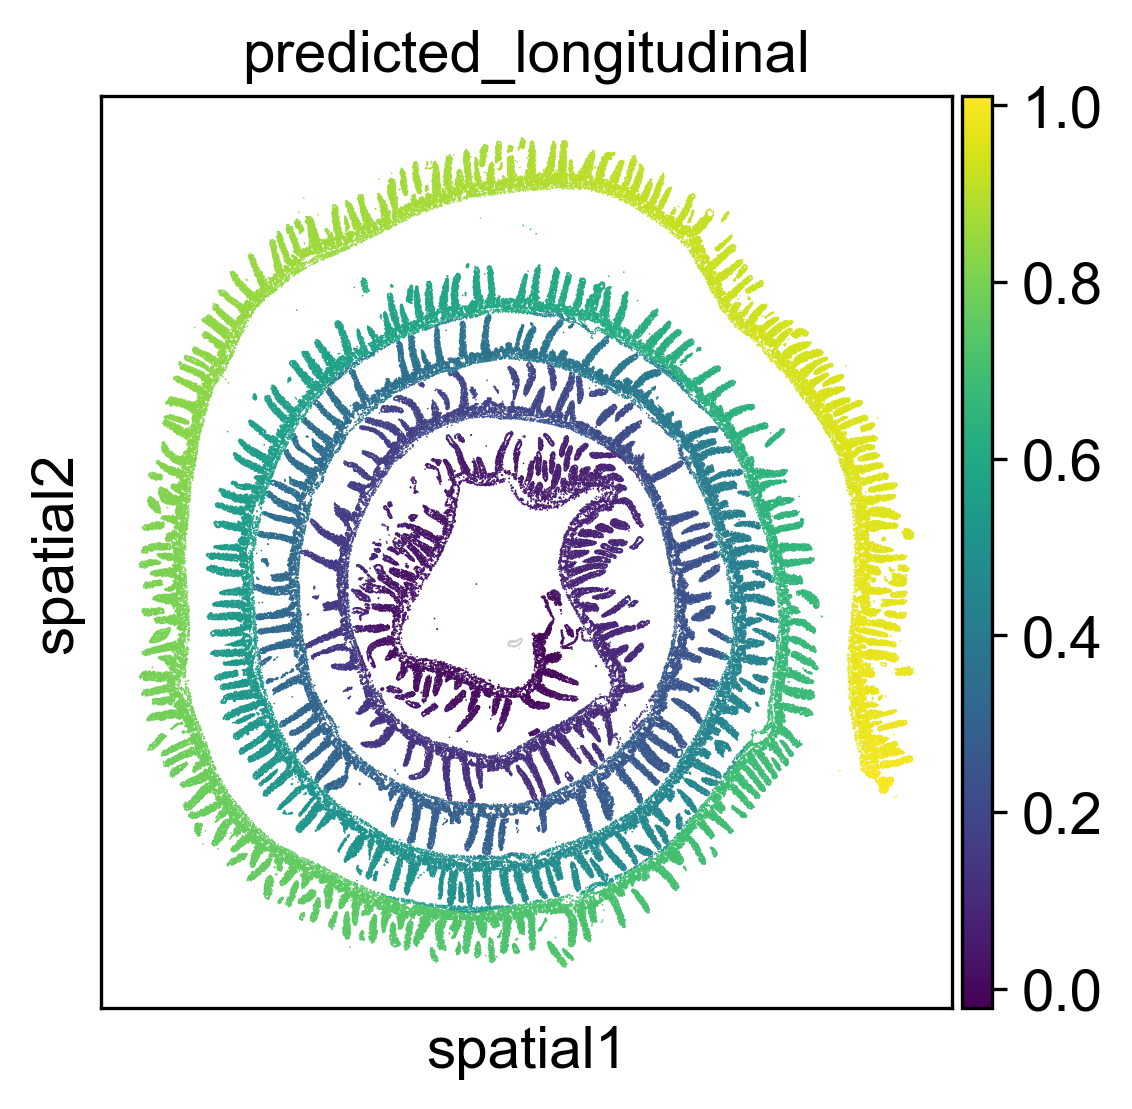

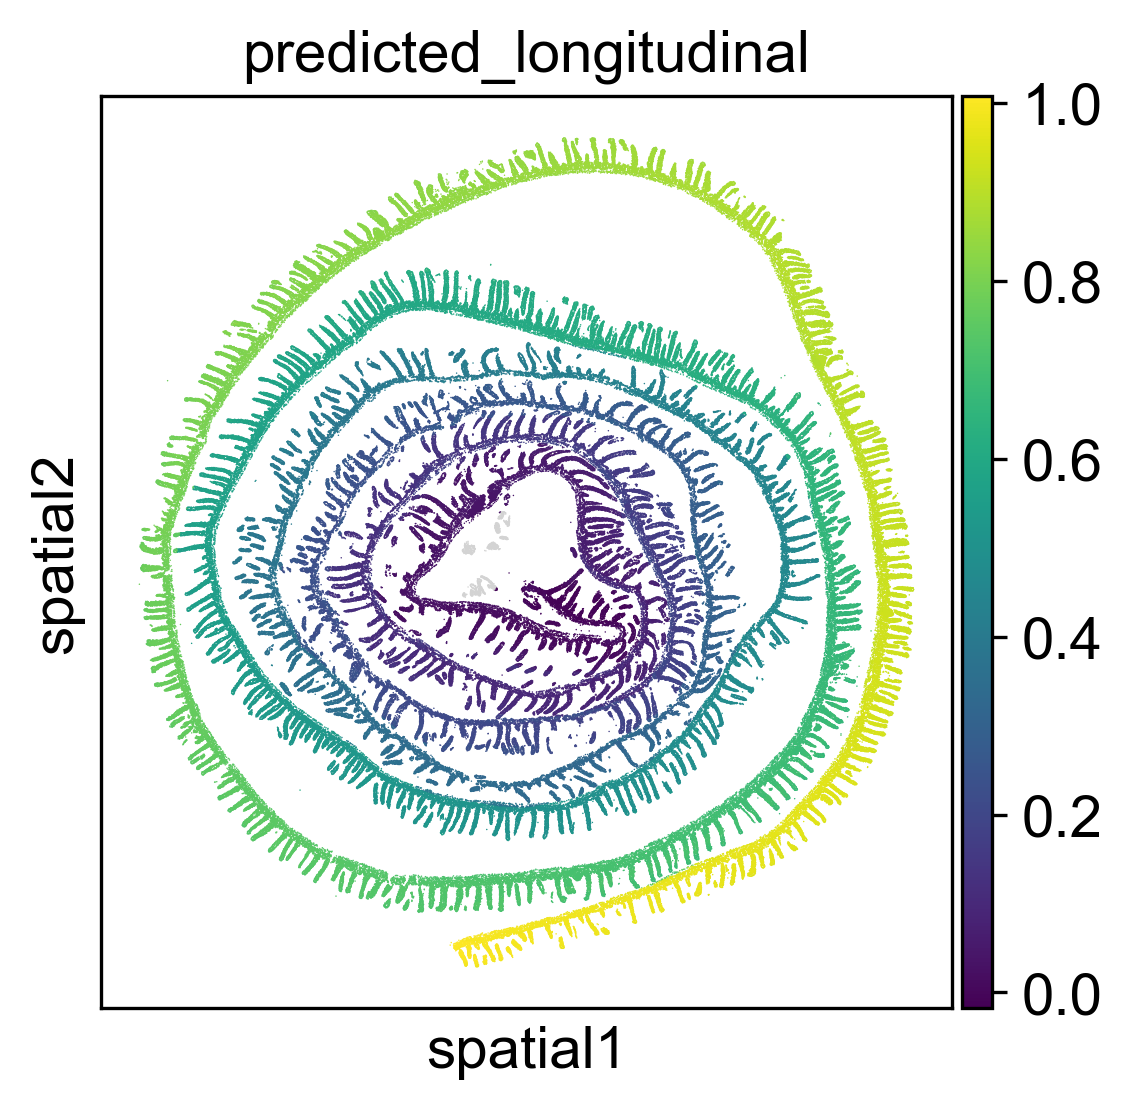

In [38]:
for i in unique_bat:
    sc.pl.embedding(concatenated_all[concatenated_all.obs.batch == i], basis='spatial', color='predicted_longitudinal')

### Write out the final object

In [39]:
concatenated_all.write(os.path.join(output_folder, 'final_celltyped_and_axes.h5ad'))